## 모듈 import

In [1]:
import os
import sys
import pickle
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

import cvlib as cv
from torchvision import transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

## 파일 경로 관련

In [2]:
class cfg:
    train_dir = '/opt/ml/input/data/train'
    train_img_dir = f'{train_dir}/images'
    train_df_path = f'{train_dir}/train.csv'
    
    test_dir = '/opt/ml/input/data/eval'
    test_img_dir = f'{test_dir}/images'
    test_df_path = f'{test_dir}/info.csv'

In [3]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

train_df = pd.read_csv(cfg.train_df_path)
test_df = pd.read_csv(cfg.test_df_path)

In [4]:
train_df.head(5)

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [5]:
test_df.head(5)

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


## train/test data 관련 bbox 찾기

In [6]:
def get_train_bbox(threshold):
    train_bbox_conf = list()
    
    if os.path.isfile(f'train_bbox_conf_{threshold}.pickle'):
        with open(f'train_bbox_conf_{threshold}.pickle','rb') as f:
            train_bbox_conf = pickle.load(f)
        print('load train')    

    else:
        for path in tqdm(train_df.path):
            d = list()
            for i, class_id in enumerate(num2class):
                img = np.array(Image.open(glob(f'{os.path.join(cfg.train_img_dir, path, class_id)}.*')[0]))
                d.append(cv.detect_face(img, threshold=threshold))
            train_bbox_conf.append(d)
        with open(f'train_bbox_conf_{threshold}.pickle','wb') as f:
            pickle.dump(train_bbox_conf, f)
        print('save train')
        
    return train_bbox_conf

def get_test_bbox(threshold):
    test_bbox_conf = list()
    
    if os.path.isfile(f'test_bbox_conf_{threshold}.pickle'):
        with open(f'test_bbox_conf_{threshold}.pickle','rb') as f:
            test_bbox_conf = pickle.load(f)
        print('load test')    

    else:
        for path in tqdm(test_df.ImageID):
            img = np.array(Image.open(os.path.join(cfg.test_img_dir, path)))
            test_bbox_conf.append(cv.detect_face(img, threshold=threshold))
        with open(f'test_bbox_conf_{threshold}.pickle','wb') as f:
            pickle.dump(test_bbox_conf, f)
        print('save test')
        
    return test_bbox_conf

In [7]:
DETECT_FACE_THRESHOLD = 0.1

train_bbox_conf = get_train_bbox(DETECT_FACE_THRESHOLD)
test_bbox_conf = get_test_bbox(DETECT_FACE_THRESHOLD)

load train
load test


In [8]:
# threshold 기반 bbox 결정
def is_x_centered(bbox, width, threshold_x):
    return width - threshold_x < (bbox[0] + bbox[2]) < width + threshold_x

def is_y_centered(bbox, height, threshold_y):
    return height - threshold_y < (bbox[1] + bbox[3]) < height + threshold_y

def is_bbox_in_img(bbox, width, height):
    return bbox[0] > 0 and bbox[1] > 0 and bbox[2] < width and bbox[3] < height

def is_bbox_size_enough(bbox, width, height, threshold_bbox_size):
    return min(threshold_bbox_size) < (bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) / (width * height) < max(threshold_bbox_size)

def is_valid_bbox(bbox, img_size, threshold_x, threshold_y, threshold_bbox_size):
    w, h = img_size
    return is_x_centered(bbox, w, threshold_x) and is_y_centered(bbox, h, threshold_y) and \
            is_bbox_in_img(bbox, w, h) and is_bbox_size_enough(bbox, w, h, threshold_bbox_size)

In [9]:
def determine_bbox_and_confidence(df, idx, bbox_and_conf, is_train=True, threshold_x=120, threshold_y=270, threshold_bbox_size=(0.05, 0.7)):
    if is_train:
        people_idx = idx // len(num2class)
        mask_idx = idx % len(num2class)
        
        image_path = df['path'][people_idx]
        p = os.path.join(cfg.train_img_dir, image_path)
        img = Image.open(glob(f'{os.path.join(p, num2class[mask_idx])}.*')[0])
        
        img_width = img.size[0] # 384
        img_height = img.size[1] # 512


        is_avg_bb = True
        center_crop_x = 150
        center_crop_y = 200
        b = [(img_width - center_crop_x) / 2, (img_height - center_crop_y) / 2, (img_width + center_crop_x) / 2, (img_height + center_crop_y) / 2]

        for i, bb in enumerate(bbox_and_conf[people_idx][mask_idx][0]):
            confidence = bbox_and_conf[people_idx][mask_idx][1][i]
            if is_valid_bbox(bb, (img_width, img_height), threshold_x, threshold_y, threshold_bbox_size):
                b = bb
                is_avg_bb = False
                break
    else:
        image_path = df['ImageID'][idx]
        img = Image.open(os.path.join(cfg.test_img_dir, image_path))

        
        img_width = img.size[0] # 384
        img_height = img.size[1] # 512


        is_avg_bb = True
        center_crop_x = 150
        center_crop_y = 200
        b = [(img_width - center_crop_x) / 2, (img_height - center_crop_y) / 2, (img_width + center_crop_x) / 2, (img_height + center_crop_y) / 2]

        for i, bb in enumerate(bbox_and_conf[idx][0]):
            confidence = bbox_and_conf[idx][1][i]
            if is_valid_bbox(bb, (img_width, img_height), threshold_x, threshold_y, threshold_bbox_size):
                b = bb
                is_avg_bb = False
                break

    if is_avg_bb:
        confidence = 0

    return b, confidence

In [10]:
def image_show_with_bbox(image_path, bboxs):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.add_patch(patches.Rectangle((bboxs[0], bboxs[1]),
                                    bboxs[2] - bboxs[0], bboxs[3] - bboxs[1],
                                    edgecolor = 'red',
                                    fill=False))
    ax.imshow(img)
    plt.show()

## train/test data bbox 결정하기

In [11]:
cnt_train_no_bbox = 0
cnt_train_bbox = 0

train_bboxs = list()
train_cnfs = list()
for idx in range(len(train_bbox_conf) * len(num2class)):
    bbox, cnf = determine_bbox_and_confidence(train_df, idx, train_bbox_conf)
    if cnf != 0:
        cnt_train_bbox += 1
    else:
        cnt_train_no_bbox += 1
    train_bboxs.append(bbox)
    train_cnfs.append(cnf)
        
cnt_train_bbox, cnt_train_no_bbox

(18808, 92)

In [12]:
cnt_test_no_bbox = 0
cnt_test_bbox = 0

test_bboxs = list()
test_cnfs = list()
for idx in range(len(test_bbox_conf)):
    bbox, cnf = determine_bbox_and_confidence(test_df, idx, test_bbox_conf, is_train=False)
    if cnf != 0:
        cnt_test_bbox += 1
    else:
        cnt_test_no_bbox += 1
    test_bboxs.append(bbox)
    test_cnfs.append(cnf)
        
cnt_test_bbox, cnt_test_no_bbox

(12458, 142)

In [13]:
train_bboxs_wh = [[b[2] - b[0], b[3] - b[1]] for b in train_bboxs]
test_bboxs_wh = [[b[2] - b[0], b[3] - b[1]] for b in test_bboxs]

train_cnfs_df = pd.DataFrame(train_cnfs).rename(columns={0: 'confidence'})
test_cnfs_df = pd.DataFrame(test_cnfs).rename(columns={0: 'confidence'})

train_bboxs_df = pd.DataFrame(train_bboxs).rename(columns={0: 'top-left-X', 1: 'top-left-Y', 2: 'bottom-right-X', 3: 'bottom-right-Y'})
test_bboxs_df = pd.DataFrame(test_bboxs).rename(columns={0: 'top-left-X', 1: 'top-left-Y', 2: 'bottom-right-X', 3: 'bottom-right-Y'})

train_bboxs_wh = pd.DataFrame(train_bboxs_wh).rename(columns={0: 'width', 1: 'height'})
test_bboxs_wh = pd.DataFrame(test_bboxs_wh).rename(columns={0: 'width', 1: 'height'})



masks = list()
for i in range(len(train_cnfs_df)):
    if i % len(num2class) == 0:
        masks.append('incorrect mask')
    elif i % len(num2class) == 6:
        masks.append('normal')
    else:
        masks.append('mask')
        
train_cnfs_df['mask'] = masks
train_bboxs_df['mask'] = masks
train_bboxs_wh['mask'] = masks

## Confidence, bbox의 위치와 크기 비교하기

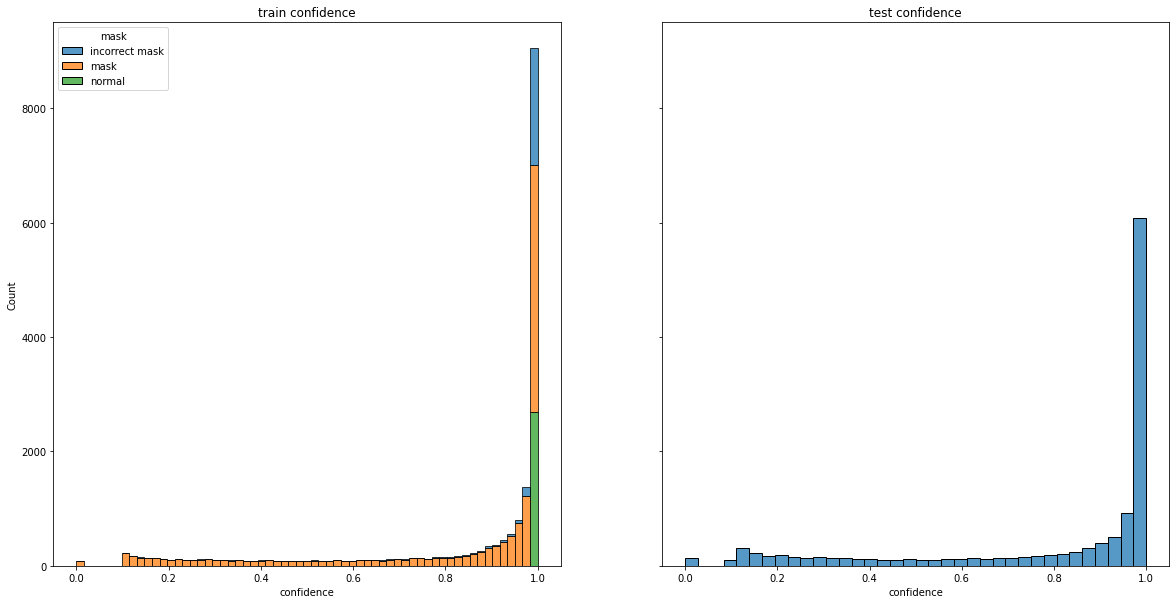

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.histplot(x='confidence', hue='mask', data=train_cnfs_df, ax=axes[0], multiple='stack')
sns.histplot(x='confidence', data=test_cnfs_df, ax=axes[1])

axes[0].set_title('train confidence')
axes[1].set_title('test confidence')

plt.show()

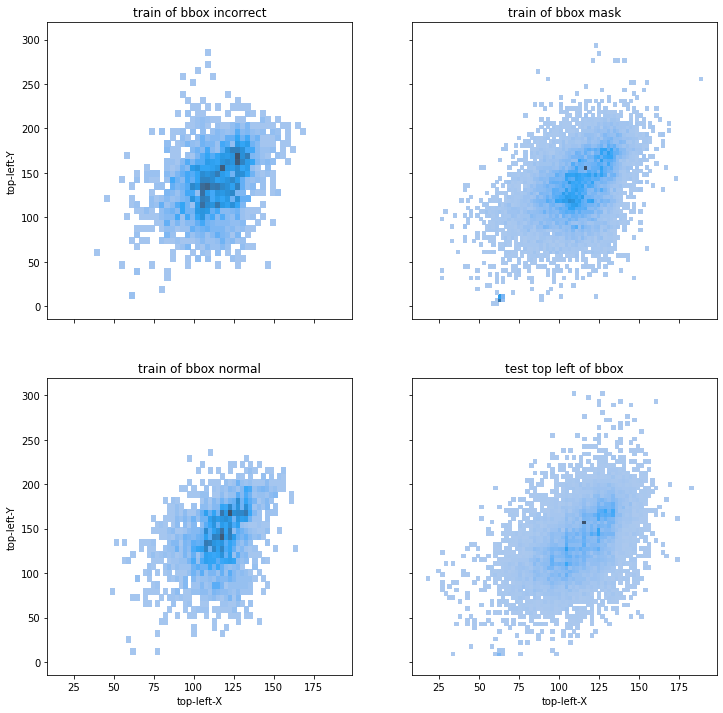

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

axes[0][0].set_title('train of bbox incorrect')
axes[0][1].set_title('train of bbox mask')
axes[1][0].set_title('train of bbox normal')
axes[1][1].set_title('test top left of bbox')

sns.histplot(x='top-left-X', y='top-left-Y', data=train_bboxs_df[train_bboxs_df.index % 7 == 0], ax=axes[0][0])
sns.histplot(x='top-left-X', y='top-left-Y', data=train_bboxs_df[(train_bboxs_df.index % 7 < 6) & (train_bboxs_df.index % 7 > 0)], ax=axes[0][1])
sns.histplot(x='top-left-X', y='top-left-Y', data=train_bboxs_df[train_bboxs_df.index % 7 == 6], ax=axes[1][0])
sns.histplot(x='top-left-X', y='top-left-Y', data=test_bboxs_df, ax=axes[1][1])

# fig.set_title('top left of bbox')
plt.show()

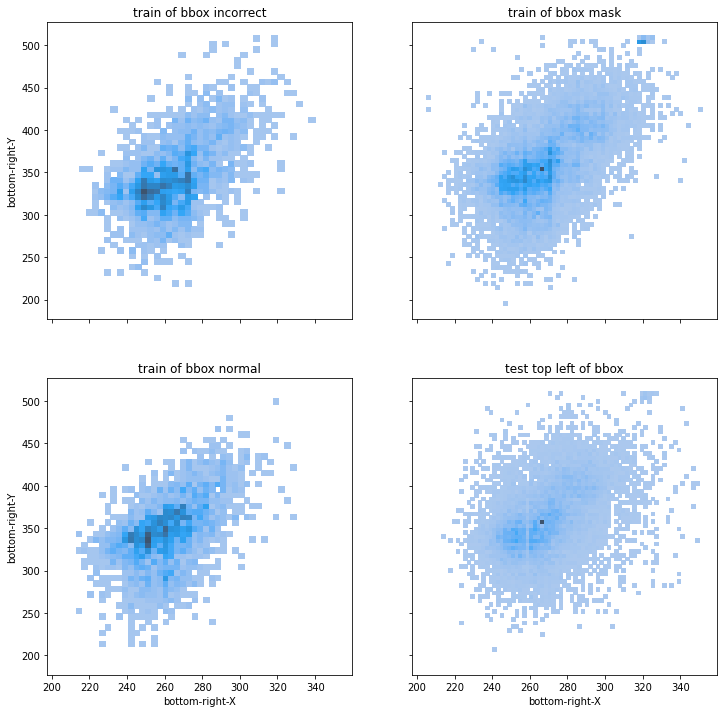

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

axes[0][0].set_title('train of bbox incorrect')
axes[0][1].set_title('train of bbox mask')
axes[1][0].set_title('train of bbox normal')
axes[1][1].set_title('test top left of bbox')

sns.histplot(x='bottom-right-X', y='bottom-right-Y', data=train_bboxs_df[train_bboxs_df.index % 7 == 0], ax=axes[0][0])
sns.histplot(x='bottom-right-X', y='bottom-right-Y', data=train_bboxs_df[(train_bboxs_df.index % 7 < 6) & (train_bboxs_df.index % 7 > 0)], ax=axes[0][1])
sns.histplot(x='bottom-right-X', y='bottom-right-Y', data=train_bboxs_df[train_bboxs_df.index % 7 == 6], ax=axes[1][0])
sns.histplot(x='bottom-right-X', y='bottom-right-Y', data=test_bboxs_df, ax=axes[1][1])

plt.show()

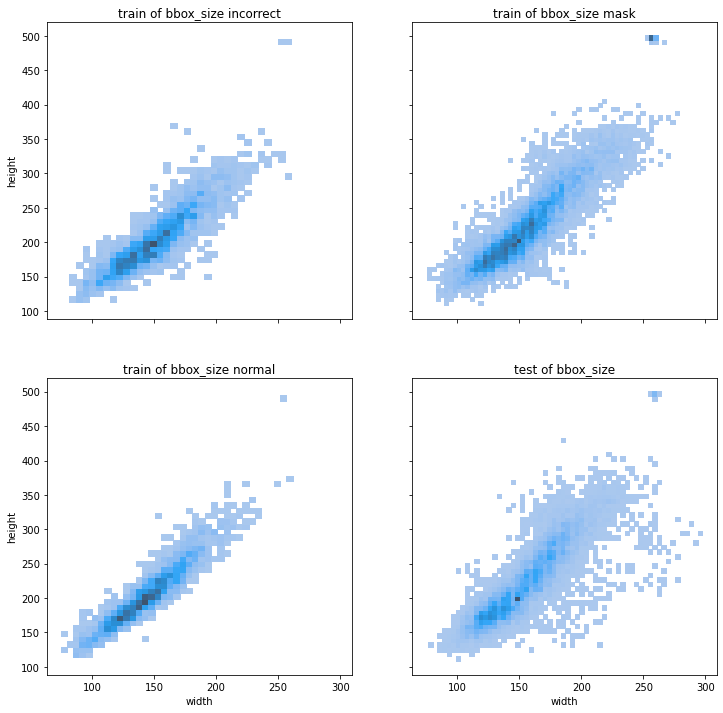

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

axes[0][0].set_title('train of bbox_size incorrect')
axes[0][1].set_title('train of bbox_size mask')
axes[1][0].set_title('train of bbox_size normal')
axes[1][1].set_title('test of bbox_size')

sns.histplot(x='width', y='height', data=train_bboxs_wh[train_bboxs_wh.index % 7 == 0], ax=axes[0][0])
sns.histplot(x='width', y='height', data=train_bboxs_wh[(train_bboxs_wh.index % 7 < 6) & (train_bboxs_wh.index % 7 > 0)], ax=axes[0][1])
sns.histplot(x='width', y='height', data=train_bboxs_wh[train_bboxs_wh.index % 7 == 6], ax=axes[1][0])
sns.histplot(x='width', y='height', data=test_bboxs_wh, ax=axes[1][1])

plt.show()

## Outlier 확인하기

In [ ]:
# img_idx = train_bboxs_wh['height'].idxmax()
# img_idx = np.random.randint(len(train_bboxs))
img_idx = train_bboxs_df['top-left-X'].idxmin()

people_idx = img_idx // len(num2class)
mask_idx = img_idx % len(num2class)

image_path = train_df['path'][people_idx]
p = os.path.join(cfg.train_img_dir, image_path)
img_pth = glob(f'{os.path.join(p, num2class[mask_idx])}.*')[0]

print(train_cnfs[img_idx])
image_show_with_bbox(img_pth, train_bboxs[img_idx])

In [ ]:
img_idx = test_bboxs_wh['height'].idxmax()
# img_idx = np.random.randint(len(test_bboxs))
# img_idx = test_bboxs_df['top-left-X'].idxmax()


image_path = test_df['ImageID'][img_idx]
img_pth = os.path.join(cfg.test_img_dir, image_path)

print(img_idx, test_cnfs[img_idx])
print(test_bbox_conf[img_idx][0])
print(test_bbox_conf[img_idx][1])
image_show_with_bbox(img_pth, test_bboxs[img_idx])